In [1]:
from siuba import *
from plotnine import *
from calitp.tables import tbl
from siuba.sql import LazyTbl
from siuba.experimental import completer

# for all the feeds we consume, how many publish the following fields:

# How many feeds publish stops.tts_stop_name?


In [2]:
tbl_feed_info = (tbl.gtfs_schedule.feed_info())

In [3]:
tbl_stops = (tbl.gtfs_schedule.stops())

In [4]:
tbl_feed_stops = (
    tbl_stops
    >>left_join (
        _,  tbl_feed_info, ["calitp_itp_id", "calitp_url_number"],
    )
    >> inner_join(_, tbl.views.gtfs_agency_names(), ["calitp_itp_id", "calitp_url_number"])
)

In [5]:
(tbl_feed_stops
  >> group_by(_.calitp_itp_id, _.calitp_url_number, _.agency_name)
  >> summarize(n_filled_entries = _.tts_stop_name.notna().astype(int).sum())
  >> count(_.n_filled_entries)
)

,n_filled_entries,n
0,0,189


# How many feeds publish stops.tts_stop_name? `none`

# How many Stops publish wheelchair_boarding?

##For parentless stops:
0 or empty - No accessibility information for the stop.
1 - Some vehicles at this stop can be boarded by a rider in a wheelchair.
2 - Wheelchair boarding is not possible at this stop.

For child stops:
0 or empty - Stop will inherit its wheelchair_boarding behavior from the parent station, if specified in the parent.
1 - There exists some accessible path from outside the station to the specific stop/platform.
2 - There exists no accessible path from outside the station to the specific stop/platform.

For station entrances/exits:
0 or empty - Station entrance will inherit its wheelchair_boarding behavior from the parent station, if specified for the parent.
1 - Station entrance is wheelchair accessible.
2 - No accessible path from station entrance to stops/platforms.


In [6]:
wheelchair_boarding = tbl_feed_stops >> select(_.wheelchair_boarding) >> collect()

In [7]:
tbl_wheelchair_boarding = (
    tbl_feed_stops 
        >> count(_.calitp_itp_id, _.calitp_url_number, _.wheelchair_boarding) 
        >> count(_.wheelchair_boarding)
)
#n is number of feeds where WC value of 0

In [8]:
tbl_wheelchair_boarding

,wheelchair_boarding,n
0,0,140
1,None,43
2,1,43
3,2,9


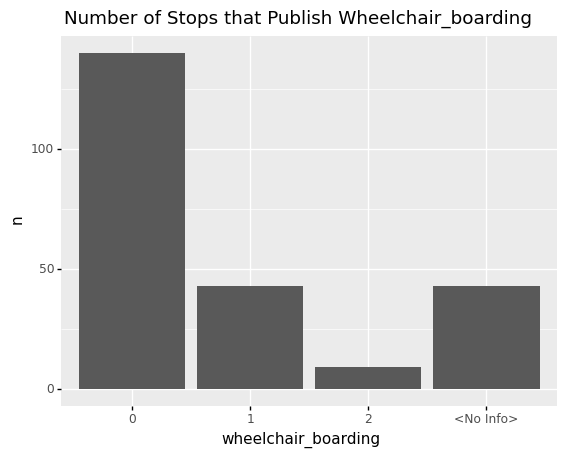

<ggplot: (8792737625835)>

In [9]:
from siuba.dply.forcats import fct_lump
(
    tbl_wheelchair_boarding
    >> collect()
    >> mutate(wheelchair_boarding = fct_lump(_.wheelchair_boarding.fillna("<No Info>"), n = 4, w = _.n))    
    >> ggplot(aes("wheelchair_boarding", "n"))
    + geom_col()
    + ggtitle("Number of Stops that Publish Wheelchair_boarding ")
)


# How many trips publish wheelchair_accessibility?

In [10]:
tbl_wheelchair_trips = (
    tbl.gtfs_schedule.trips()
)

In [11]:
tbl_feed_trips = (
    tbl_wheelchair_trips
    >> left_join (
            _,  tbl_feed_info, ["calitp_itp_id", "calitp_url_number"],
    )
    >> inner_join(_, tbl.views.gtfs_agency_names(), ["calitp_itp_id", "calitp_url_number"])
)

In [12]:
feed_trip_counts = (
    tbl_feed_trips
    >> count(_.calitp_itp_id, _.calitp_url_number, _.agency_name, _.wheelchair_accessible
        )
    >> count(_.wheelchair_accessible)
)

In [13]:
feed_trip_counts

,wheelchair_accessible,n
0,None,157
1,1,21
2,0,13
3,2,2


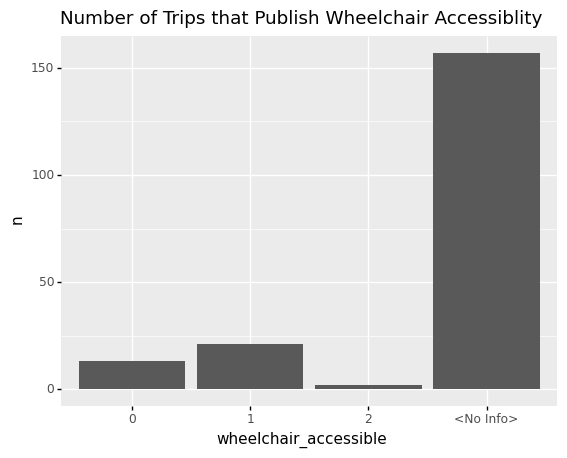

<ggplot: (8792827785186)>

In [14]:
(
    feed_trip_counts
    >> collect()
    >> mutate(wheelchair_accessible = fct_lump(_.wheelchair_accessible.fillna("<No Info>"), n = 4, w = _.n))    
    >> ggplot(aes("wheelchair_accessible", "n"))
    + geom_col()
    + ggtitle("Number of Trips that Publish Wheelchair Accessiblity")
)


# Are There trips without wheelchair boarding that have stop wheelchair boarding?

# How many feeds publish specific .txt files?

In [15]:
tbl_file_updates = (tbl.gtfs_schedule_history.calitp_files_updates())

In [16]:
tbl_feed_file_updates = (
    tbl_file_updates
    >> left_join (
            _,  tbl_feed_info, ["calitp_itp_id", "calitp_url_number"],
    )
    >> inner_join(_, tbl.views.gtfs_agency_names(), ["calitp_itp_id", "calitp_url_number"])
)

In [17]:
feed_file_updates = (
    tbl_feed_file_updates
    >> count(_.calitp_itp_id, _.calitp_url_number, _.agency_name, _.name
        )
    >> count(_.name, _.agency_name) 
    >> collect()
)

# How many feeds publish fare_leg_rules.txt? (Fares v.2) 

In [18]:
feed_file_updates >> filter(_.name == "fare_leg_rules.txt")

,name,agency_name,n
441,fare_leg_rules.txt,Rosemead Explorer,1
631,fare_leg_rules.txt,Auburn Transit,1
674,fare_leg_rules.txt,Avalon Transit,1
907,fare_leg_rules.txt,Bell Gardens,1
943,fare_leg_rules.txt,Bellflower Bus,1
954,fare_leg_rules.txt,Santa Barbara Metropolitan Transit District,1
1174,fare_leg_rules.txt,Calaveras Transit,1
1220,fare_leg_rules.txt,Simi Valley Transit,1
1520,fare_leg_rules.txt,Susanville Indian Rancheria Public Transportat...,1
1567,fare_leg_rules.txt,Tahoe Transportation,1


In [19]:
feed_file_updates >> filter(_.name == "fare_leg_rules.txt") >> count(_.name)

,name,n
0,fare_leg_rules.txt,32


# How many feeds publish fare_leg_rules.txt? `26`

# How many feeds publish fare_rules.txt? (Fares v1)

In [20]:
feed_file_updates >> filter(_.name == "fare_rules.txt")

,name,agency_name,n
10,fare_rules.txt,San Francisco Bay Ferry,2
17,fare_rules.txt,SamTrans,2
32,fare_rules.txt,SolTrans,2
82,fare_rules.txt,Fairfield and Suisun Transit,2
115,fare_rules.txt,Porterville Transit,1
...,...,...,...
3861,fare_rules.txt,Pasadena Transit,1
3890,fare_rules.txt,Caltrain,1
3914,fare_rules.txt,Petaluma Transit,1
3934,fare_rules.txt,Placer County Transit,1


# How many feeds publish fare_rules.txt? `152`

# How many feeds publish pathways.txt?

In [21]:
feed_file_updates >> filter(_.name == "pathways.txt")

,name,agency_name,n
3396,pathways.txt,MTC 511,1


# How many feeds publish levels.txt? `1`

# How many feeds publish levels.txt?

In [22]:
feed_file_updates >> filter(_.name == "levels.txt")

,name,agency_name,n
3387,levels.txt,MTC 511,1


# How many feeds publish levels.txt? `1`

# What percentage of feeds have atleast 1 or 2 in their stops.wheelchair or trips.accessibility?

In [23]:
pk_feed = ["calitp_itp_id", "calitp_url_number"]

tbl_feeds_raw = (
    tbl.views.gtfs_agency_names()
    >> left_join(_, tbl.gtfs_schedule.feed_info(), pk_feed)
    >> select(_.calitp_itp_id, _.calitp_url_number, _.agency_name, _.feed_publisher_name)
    >> mutate(feed_publisher_name = _.feed_publisher_name.fillna("Missing Publisher Name"))
    # Remove itp id 200 (MTC-511), since they have many feed_info files
    >> filter(_.calitp_itp_id != 200)
)

tbl_feed_metrics_stops = (
    tbl.gtfs_schedule.stops()
    >> inner_join(_, tbl_feeds_raw, pk_feed)
    >> mutate(
        wheelchair_boarding=_.wheelchair_boarding.fillna("missing"),
        wheelchair_marked=(_.wheelchair_boarding == "1")
        | (_.wheelchair_boarding == "2"),
    )
    >> group_by(*pk_feed)
    >> summarize(prop_stop_wheelchair_marked=_.wheelchair_marked.astype(int).mean())
    >> mutate(has_stop_wheelchair_entry = _.prop_stop_wheelchair_marked > 0)
)

tbl_feed_metrics_trips = (tbl.gtfs_schedule.trips() >> inner_join(_, tbl_feeds_raw, pk_feed)
    >> mutate(
        wheelchair_accessible=_.wheelchair_accessible.fillna("missing"),
        wheelchair_marked=(_.wheelchair_accessible == "1")
        | (_.wheelchair_accessible == "2"),
    )
    >> group_by(*pk_feed)
    >> summarize(prop_trip_wheelchair_marked=_.wheelchair_marked.astype(int).mean())
    >> mutate(has_trip_wheelchair_entry = _.prop_trip_wheelchair_marked > 0)
)

In [24]:
tbl_feed_metrics = (
    tbl_feeds_raw
    >> inner_join(_, tbl_feed_metrics_stops, pk_feed)
    >> inner_join(_, tbl_feed_metrics_trips, pk_feed)
    >> collect()
)

In [25]:
tbl_publisher_counts = (tbl_feed_metrics >> count(_.feed_publisher_name) >> rename(ttl_publisher_feeds = "n"))

### Counting each combination of no trips or stops wheelchair entries

In [26]:
tbl_feed_metrics >> count(_.has_trip_wheelchair_entry, _.has_stop_wheelchair_entry)

,has_trip_wheelchair_entry,has_stop_wheelchair_entry,n
0,False,False,137
1,False,True,30
2,True,False,8
3,True,True,13


### Percentage with a trip or stop wheelchair entry

In [27]:
(
    tbl_feed_metrics
    >> count(
        has_trip_or_stop_entry=_.has_trip_wheelchair_entry | _.has_stop_wheelchair_entry
    )
    >> mutate(prop=_.n / _.n.sum())
)

,has_trip_or_stop_entry,n,prop
0,False,137,0.728723
1,True,51,0.271277


## Vendor lists WITHOUT entries


In [28]:
# There are 32 vendors (although we are counting "missing" as a vendor)
tbl_publisher_counts >> count()

,n
0,32


### Vendors with no stop wheelchair entries

In [29]:
# count
(
    tbl_feed_metrics
    >> filter(~_.has_stop_wheelchair_entry)
    >> count(_.feed_publisher_name, sort=True)
    >> rename(n_no_stop_entry = "n")
    >> left_join(_, tbl_publisher_counts, "feed_publisher_name")
    >> mutate(prop_no_stop_entry = _.n_no_stop_entry / _.ttl_publisher_feeds)
)

,feed_publisher_name,n_no_stop_entry,ttl_publisher_feeds,prop_no_stop_entry
0,"Trillium Solutions, Inc.",84,113,0.743363
1,Missing Publisher Name,25,27,0.925926
2,511 SF Bay,9,12,0.750000
3,GMV Syncromatics,5,5,1.000000
4,Los Angeles County Metropolitan Transportation...,2,2,1.000000
5,Big Blue Bus,1,1,1.000000
6,Optibus,1,1,1.000000
7,Unitrans,1,1,1.000000
8,Bay Area Rapid Transit,1,1,1.000000
9,Transnnovation Inc,1,1,1.000000


### Vendors with no trip wheelchair entries

In [30]:
(
    tbl_feed_metrics
    >> filter(~_.has_trip_wheelchair_entry)
    >> count(_.feed_publisher_name, sort=True)
    >> rename(n_no_trip_entry = "n")
    >> left_join(_, tbl_publisher_counts, "feed_publisher_name")
    >> mutate(prop_no_trip_entry = _.n_no_trip_entry / _.ttl_publisher_feeds)
)

,feed_publisher_name,n_no_trip_entry,ttl_publisher_feeds,prop_no_trip_entry
0,"Trillium Solutions, Inc.",111,113,0.982301
1,Missing Publisher Name,24,27,0.888889
2,511 SF Bay,9,12,0.750000
3,GMV Syncromatics,5,5,1.000000
4,Los Angeles County Metropolitan Transportation...,2,2,1.000000
5,Culver CityBus,1,1,1.000000
6,Optibus,1,1,1.000000
7,Big Blue Bus,1,1,1.000000
8,Transnnovation Inc,1,1,1.000000
9,Santa Clara Valley Transportation Authority,1,1,1.000000


## Vendor lists WITH entries

### Vendors with stop wheelchair entries

In [31]:
# count
(
    tbl_feed_metrics
    >> filter(_.has_stop_wheelchair_entry)
    >> count(_.feed_publisher_name, sort=True)
    >> rename(n_stop_entry = "n")
    >> left_join(_, tbl_publisher_counts, "feed_publisher_name")
    >> mutate(prop_stop_entry = _.n_stop_entry / _.ttl_publisher_feeds)
)

,feed_publisher_name,n_stop_entry,ttl_publisher_feeds,prop_stop_entry
0,"Trillium Solutions, Inc.",29,113,0.256637
1,511 SF Bay,3,12,0.250000
2,Transnnovation,3,3,1.000000
3,Missing Publisher Name,2,27,0.074074
4,MST,1,1,1.000000
5,MTS,1,1,1.000000
6,NCTD,1,1,1.000000
7,SBMTD,1,1,1.000000
8,Santa Clara Valley Transportation Authority,1,1,1.000000
9,TORRANCE TRANSIT SYSTEM,1,1,1.000000


### Vendors with trip wheelchair entries

In [32]:
(
    tbl_feed_metrics
    >> filter(_.has_trip_wheelchair_entry)
    >> count(_.feed_publisher_name, sort=True)
    >> rename(n_trip_entry = "n")
    >> left_join(_, tbl_publisher_counts, "feed_publisher_name")
    >> mutate(prop_trip_entry = _.n_trip_entry / _.ttl_publisher_feeds)
)

,feed_publisher_name,n_trip_entry,ttl_publisher_feeds,prop_trip_entry
0,511 SF Bay,3,12,0.250000
1,Missing Publisher Name,3,27,0.111111
2,Transnnovation,3,3,1.000000
3,"Trillium Solutions, Inc.",2,113,0.017699
4,Bay Area Rapid Transit,1,1,1.000000
5,City of Lodi,1,1,1.000000
6,MST,1,1,1.000000
7,MTS,1,1,1.000000
8,NCTD,1,1,1.000000
9,SBMTD,1,1,1.000000


# What Providers have data in stops.parent_station at least once?

In [33]:
tbl_transit_stacks =tbl.transitstacks.provider_info() >>mutate(calitp_itp_id = _.itp_id)

In [34]:
tbl_transit_stacks >> count(_.transit_provider)
    #>> mutate(total_transit = _.transit_provider.sum())


,transit_provider,n
0,Easy Lift Transportation,2
1,Balboa Island Ferry,1
2,Amtrak,1
3,Bakersfield Airport Valet Express,1
4,Angel Island-Tiburon Ferry Company,1


In [35]:
tbl_gtfs_stops = tbl.gtfs_schedule.stops()

In [36]:
tbl_transit_provider_join = (
    tbl_transit_stacks
    >>left_join(_, tbl_gtfs_stops, "calitp_itp_id")
)

In [37]:
tbl_transit_provider_join

,transit_provider,itp_id,ntd_id,legacy_ntd_id,modes,operates_transit,reporter_type,service_area_density,primary_uza,uza_name,...,wheelchair_boarding,stop_timezone,stop_desc,stop_code,calitp_url_number,tts_stop_name,location_type,platform_code,calitp_extracted_at,parent_station
0,Greyhound,12,None,None,IB,Y,None,Mix,None,None,...,None,None,None,None,NaN,None,None,None,None,None
1,Amtrak,13,None,None,IR,Y,None,Urban,None,None,...,None,None,None,None,NaN,None,None,None,None,None
2,Angel Island-Tiburon Ferry Company,15,None,None,FB,Y,None,Rural,None,None,...,0,America/Los_Angeles,None,None,0.0,None,0,None,2021-05-03,None
3,Angel Island-Tiburon Ferry Company,15,None,None,FB,Y,None,Rural,None,None,...,0,America/Los_Angeles,None,None,0.0,None,0,None,2021-05-03,None
4,Angel Island-Tiburon Ferry Company,15,None,None,FB,Y,None,Rural,None,None,...,0,America/Los_Angeles,None,None,0.0,None,0,None,2021-05-03,None


In [38]:
tbl_transit_stacks >> count()

,n
0,400


In [39]:
tbl_transit_provider_join >> filter (_.calitp_url_number.isna()) >> count()
#transit providers that are not in the feeds

,n
0,224


In [40]:
tbl_transit_provider_join >> filter (_.calitp_url_number.isna()) >> collect()

,transit_provider,itp_id,ntd_id,legacy_ntd_id,modes,operates_transit,reporter_type,service_area_density,primary_uza,uza_name,...,wheelchair_boarding,stop_timezone,stop_desc,stop_code,calitp_url_number,tts_stop_name,location_type,platform_code,calitp_extracted_at,parent_station
0,Greyhound,12,None,None,IB,Y,None,Mix,NaN,None,...,None,None,None,None,None,None,None,None,None,None
1,Amtrak,13,None,None,IR,Y,None,Urban,NaN,None,...,None,None,None,None,None,None,None,None,None,None
2,Bakersfield Airport Valet Express,27,None,None,CB,Y,None,Mix,NaN,None,...,None,None,None,None,None,None,None,None,None,None
3,Balboa Island Ferry,28,None,None,FB,Y,None,Rural,NaN,None,...,None,None,None,None,None,None,None,None,None,None
4,Coronado Ferry,32,None,None,FB,Y,None,Urban,NaN,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,California Vanpool Authority,53,90230,9230,VP,Y,Full Reporter,Urban,333.0,"Hanford, CA",...,None,None,None,None,None,None,None,None,None,None
220,TRACER,341,90197,9197,"MB,DR",Y,Reduced Reporter,Mix,334.0,"Tracy, CA",...,None,None,None,None,None,None,None,None,None,None
221,Davis Community Transit,90,90167,9167,DR,Y,Reduced Reporter,Mix,382.0,"Davis, CA",...,None,None,None,None,None,None,None,None,None,None
222,San Luis Obispo Regional Transit Authority,289,90206,9206,"DR,MB",Y,Full Reporter,Mix,447.0,"San Luis Obispo, CA",...,None,None,None,None,None,None,None,None,None,None


In [41]:
tbl_feed_metrics_parent = (
    tbl_transit_provider_join
    >> inner_join(_, tbl_feeds_raw, pk_feed)
    >> filter(_.parent_station.notna())
    >> collect() 
    >> group_by(*pk_feed)
    >> count (_.parent_station, _.transit_provider, _.feed_publisher_name)
)